# DATA AUGMENTATION WITH A VAE WITH CONVOLUTIONAL LAYERS

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import tensorflow as tf    

In [2]:
####### lOAD DATA ##########

### COPY FROM BUCKET TO LOCAL STORAGE ####
# !gsutil -m cp gs://dataham/Dataset/MEL/train_mel.npy ./dataset
# !gsutil -m cp gs://dataham/Dataset/MEL/test_mel.npy ./dataset
# !gsutil -m cp gs://dataham/Dataset/NV/train_nv.npy ./dataset
# !gsutil -m cp gs://dataham/Dataset/NV/test_nv.npy ./dataset


#### LOAD DATA FROM LOCAL STORAGE ### 

###### MEL: class 1 ######
x_mel_train, x_mel_test = np.load("./dataset/train_mel.npy"), np.load("./dataset/test_mel.npy")
y_mel_train, y_mel_test = np.ones((x_mel_train.shape[0], )), np.ones((x_mel_test.shape[0], ))


###### NV: class 0 ######
x_nv_train, x_nv_test = np.load("./dataset/train_nv.npy"), np.load("./dataset/test_nv.npy")
y_nv_train, y_nv_test = np.zeros((x_nv_train.shape[0], )), np.zeros((x_nv_test.shape[0], ))

In [4]:
x_mel_train.shape, x_mel_test.shape

((887, 128, 128, 3), (226, 128, 128, 3))

In [6]:
x_nv_train.shape , x_nv_test.shape

((5365, 128, 128, 3), (1340, 128, 128, 3))

In [3]:
####### PARAMS FOR THE VAE: CLASS MEL ########

model_params_mel = { "x_train": x_mel_train,
                    "x_val": x_mel_test,
                    "img_rows": 128, 
                    "img_cols": 128,
                    "img_chns" :  3,
                    "latent_dim" : 3,
                    "intermediate_dim" : 128,
                    "epsilon_std" : 1.0,
                    "epochs" : 100,
                    'filters' : 32,
                    "kernel_size" : 3,
                    "batch_size" : 16,
                    "name_model":"VAE_MEL"
                    }

In [5]:
####### PARAMS FOR THE VAE: CLASS MEL ########

model_params_nv = { "x_train": x_nv_train,
                    "x_val": x_nv_test,
                    "img_rows": 128, 
                    "img_cols": 128,
                    "img_chns" :  3,
                    "latent_dim" : 3,
                    "intermediate_dim" : 128,
                    "epsilon_std" : 1.0,
                    "epochs" : 50,
                    'filters' : 8,
                    "kernel_size" : 2,
                    "batch_size" : 16,
                    "name_model":"VAE_NV"
                    }

In [4]:
"""

The following model is fit on HAM10000 datase with only observations of class MEL

"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint

img_rows, img_cols, img_chns = 128, 128, 3


def evaluate_VAE( x_train = x_mel_train, 
                 x_val = x_mel_test,
                 img_rows = 128, 
                img_cols  = 128,
                img_chns =  3,
                latent_dim = 2,
                intermediate_dim = 128,
                epsilon_std = 1.0,
                epochs = 50,
                filters = 32,
                kernel_size = 3,
                batch_size = 32,
                name_model = 'VAE'):


    K.clear_session()

    # tensorflow uses channels_last
    # theano uses channels_first
    if K.image_data_format() == 'channels_first':
        original_img_size = (img_chns, img_rows, img_cols)
    else:
        original_img_size = (img_rows, img_cols, img_chns)


    # encoder architecture
    x = Input(shape=original_img_size)

    #x = Input(shape=(32,32,3))
    conv_1 = Conv2D(img_chns,
                    kernel_size=(2, 2),
                    padding='same', activation='relu')(x)
#     conv_2 = Conv2D(filters,
#                     kernel_size=(2, 2),
#                     padding='same', activation='relu',
#                     strides=(2, 2))(conv_1)
    conv_3 = Conv2D(filters,
                    kernel_size=kernel_size, ## kernel_size = 3 meaning (3,3) filter size 
                    padding='same', activation='relu',
                    strides=1)(conv_1)
    conv_4 = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu',
                    strides=1)(conv_3)
    flat = Flatten()(conv_4)
    hidden = Dense(intermediate_dim, activation='relu')(flat)

    # mean and variance for latent variables
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden) ## log of variance so take the log afterwards 

    # sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=0., stddev=epsilon_std)
        #epsilon = K.random_normal(shape=(2, 2),
            #                     mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var) * epsilon

    
    # reparametrization trick to find z out of z_mean and z_log_var
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    #z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])




    # decoder architecture
    decoder_hid = Dense(intermediate_dim, activation='relu') # FC of size 128
    decoder_upsample = Dense(int(filters * img_rows / 2 * img_cols / 2), activation='relu') # Dense(32*16*16)

    # For second dense layer 
    if K.image_data_format() == 'channels_first':
        output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
    else:
        output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)


    decoder_reshape = Reshape(output_shape[1:]) ## 16*16*32
    decoder_deconv_1 = Conv2DTranspose(filters,
                                       kernel_size = 2,
                                       padding = 'same',
                                       strides = 1,
                                       activation='relu')
    
#     decoder_deconv_2 = Conv2DTranspose(filters,
#                                        kernel_size=kernel_size,
#                                        padding='same',
#                                        strides=1,
#                                        activation='relu')
    decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                              kernel_size=(3, 3),
                                              strides=(2, 2),
                                              padding='valid',
                                              activation='relu')
    decoder_mean_squash = Conv2D(img_chns,
                                 kernel_size=2,
                                 padding='valid',
                                 activation='sigmoid')


    # Linking the layers
    hid_decoded = decoder_hid(z)

    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded = decoder_reshape(up_decoded)

    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    #     deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
    x_decoded_relu = decoder_deconv_3_upsamp(deconv_1_decoded)
    #     x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)



    # Custom loss layer
    class CustomVariationalLayer(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomVariationalLayer, self).__init__(**kwargs)

        def vae_loss(self, x, x_decoded_mean_squash):
            x = K.flatten(x)
            x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
            xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return K.mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean_squash = inputs[1]
            loss = self.vae_loss(x, x_decoded_mean_squash)
            self.add_loss(loss, inputs=inputs)
            return x


    y = CustomVariationalLayer()([x, x_decoded_mean_squash])

    ######### ENTIRE MODEL #########
    vae = Model(x, y)
    #################################
    vae.compile(optimizer='rmsprop', loss=None)
   
    ######## CALLBACKS: we will only keep the model that best fit the data based on validation loss #########
    
    model_best_path= "weights{}.hdf5".format(name_model)
    callbacks = [
                
                ModelCheckpoint(model_best_path, monitor='val_loss', save_best_only=True, verbose=0)
               
                ]
    
    ####################################
    
    ############ TRAINING: fit training data, no label necessary ##########
    vae.fit(x_train, 
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data = (x_val, None),
            callbacks=callbacks,
            verbose = 1          
            )
    ###################################################
    
        
    # encoder from learned model
    encoder = Model(x, z_mean)

    # generator / decoder from learned model
    decoder_input = Input( shape=(latent_dim,) )
    _hid_decoded = decoder_hid(decoder_input)
    _up_decoded = decoder_upsample(_hid_decoded)
    _reshape_decoded = decoder_reshape(_up_decoded)
    _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
#     _deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
    _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_1_decoded)
    _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
    generator = Model(decoder_input, _x_decoded_mean_squash, name = 'generator --decoder_VAE')   
    
    
    
    return vae, generator     

Using TensorFlow backend.


## FITTING CLASS NV AND GENERATING DATA FROM SAME UNDERLYING DISTRIBUTION

In [8]:
model_VAE_nv, generator = evaluate_VAE(**model_params_nv)

Train on 5365 samples, validate on 1340 samples
Epoch 1/50
5365/5365 [==============================] - 18s 3ms/step - loss: 10099.2023 - val_loss: 10093.1835
Epoch 2/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9851.8452 - val_loss: 10045.2128
Epoch 3/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9813.1745 - val_loss: 9893.2730
Epoch 4/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9795.4741 - val_loss: 9846.6257
Epoch 5/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9784.3963 - val_loss: 9838.5639
Epoch 6/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9773.2434 - val_loss: 9940.5856
Epoch 7/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9766.8114 - val_loss: 9836.0737
Epoch 8/50
5365/5365 [==============================] - 17s 3ms/step - loss: 9761.3920 - val_loss: 9825.6546
Epoch 9/50
5365/5365 [==============================] - 17s 3ms/step - loss: 

In [ ]:
"""
Just change folder manually here in hdfs copy 
For class NV
"""


# display images generated from randomly sampled latent vector
n = 5365
img_size = 128
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns) # x_decoded[0] is the actual image since x_decoded is shape (1,32,32,3)
        
        fname = 'generated_image_with_ld_%d_conv_%d_id_%d_epoch_train_%d'% (latent_dim, kernel_size, intermediate_dim, epochs) + '_id_'+ str(i)+ '.png'
        print(fname)
        matplotlib.image.imsave(fname, img)
        hdfs.copy_to_hdfs(fname, hdfs.project_path()+'Generated_VAE/Class_NV/VAE_model_50epochs/', overwrite=True)

In [42]:
filename = "./augmented_data/images_VAE_nv.npy"


def generate_images(generator = generator_mel, latent_dim = 3, filename = filename, verbose = False, nb_obs_power3 = 17):
    # display a 2D manifold of the digits
    n = nb_obs_power3  # figure with 17*17*17 digits
    digit_size = 128*128*3


    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))
    grid_z = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))

    #grid_x = norm.ppf(np.linspace(-10.0, 10.0, n))
    #grid_y = norm.ppf(np.linspace(-10.0, 10.0, n))
    total_aug_nv = np.empty((n**3, 128,128,3))
    iteration = 0 
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            for k,zi in enumerate(grid_z):
                # xi = input()
                # yi = input()
                # zi = input()
                z_sample = np.array([[xi, yi,zi]])
                # print z_sample
                x_decoded = generator.predict(z_sample) ## shape (1,128,128,3)
                digit = x_decoded[0]
                total_aug_nv[iteration] = digit
                iteration += 1 
                if iteration % 1000 == 0:
                    print("Nice! {} steps done already! :)".format(iteration))
                if verbose: 
                    plt.figure(figsize=(10, 10))
                    plt.imshow(digit, cmap='Greys_r')
                    plt.show()
    #             figure[j * digit_size: (j + 1) * digit_size,
    #                    k * digit_size: (k + 1) * digit_size] = digit
#         if verbose: 
#             plt.figure(figsize=(10, 10))
#             plt.imshow(figure, cmap='Greys_r')
#             plt.show()
    
    # save file
    np.save(filename, total_aug_nv )
    return total_aug_nv


In [20]:
total_aug_nv = generate_images()

Nice! 1000 steps done already! :)
Nice! 2000 steps done already! :)
Nice! 3000 steps done already! :)
Nice! 4000 steps done already! :)


In [6]:
################## COPY DATA IN BUCKET ###################

# !gsutil -m cp  ./augmented_data/images_VAE_nv.npy  gs://dataham/Dataset/VAE_DATA

Copying file://./augmented_data/images_VAE_nv.npy [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/1.8 GiB.                                      


In [12]:
### LOAD GENERATED DATA FROM CLASS NV AND CHECK IF OKAY #### 
filename = "./augmented_data/images_VAE_nv.npy"
images_gener_nv = np.load(filename)

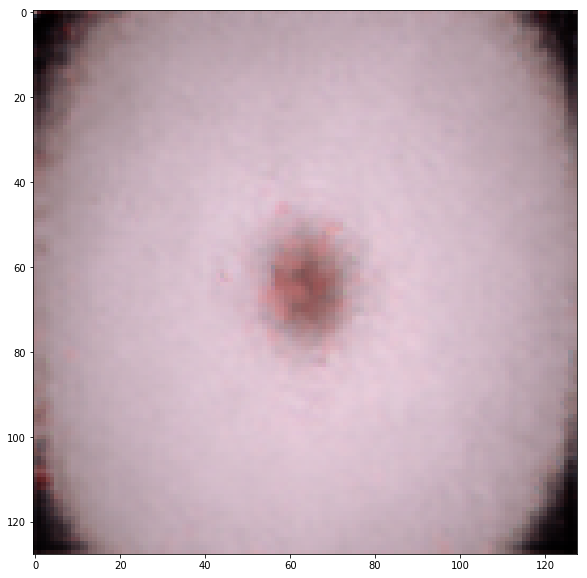

In [14]:
#### PLOT LAST IMAGE TO CHECK ###
last_image = images_gener_nv[-1]

plt.figure(figsize=(10, 10))
plt.imshow(last_image, cmap='Greys_r')
plt.show()

## FITTING CLASS MEL AND GENERATING DATA FROM SAME UNDERLYING DISTRIBUTION

In [31]:
model_VAE_mel, generator_mel = evaluate_VAE(**model_params_mel)

Train on 887 samples, validate on 226 samples
Epoch 1/100
887/887 [==============================] - 12s 13ms/step - loss: 10852.9291 - val_loss: 10803.9261
Epoch 2/100
887/887 [==============================] - 9s 11ms/step - loss: 10648.0492 - val_loss: 10695.3161
Epoch 3/100
887/887 [==============================] - 9s 10ms/step - loss: 10577.6848 - val_loss: 10768.5120
Epoch 4/100
887/887 [==============================] - 9s 11ms/step - loss: 10478.8141 - val_loss: 10418.4886
Epoch 5/100
887/887 [==============================] - 9s 11ms/step - loss: 10408.2732 - val_loss: 10346.2036
Epoch 6/100
887/887 [==============================] - 9s 11ms/step - loss: 10358.3916 - val_loss: 10604.1396
Epoch 7/100
887/887 [==============================] - 9s 11ms/step - loss: 10344.6801 - val_loss: 10414.3388
Epoch 8/100
887/887 [==============================] - 9s 11ms/step - loss: 10308.7832 - val_loss: 10293.2838
Epoch 9/100
887/887 [==============================] - 9s 11ms/step - los

In [43]:
filename_VAE_mel = "./augmented_data/images_VAE_mel_10000.npy"
### We want to generate 10,000 images of class mel 
#### for nb_obs_power3 given that we work on a grid of 3d, we need the np.power(10000, 1/3) 
#### In other words, we generate np.power(10000, 1/3) random elements along each x,y,z axis 

nb_obs_mel = 1e4
nb_obs_power3_mel = np.int(np.power(nb_obs_mel, 1/3))

total_aug_mel = generate_images(generator = generator_mel, latent_dim = 3, filename = filename_VAE_mel, verbose = False, nb_obs_power3 = nb_obs_power3_mel)

Nice! 1000 steps done already! :)
Nice! 2000 steps done already! :)
Nice! 3000 steps done already! :)
Nice! 4000 steps done already! :)
Nice! 5000 steps done already! :)
Nice! 6000 steps done already! :)
Nice! 7000 steps done already! :)
Nice! 8000 steps done already! :)
Nice! 9000 steps done already! :)


# SMART AUGMENTATION

In [20]:
model_smart_params = {  "x_train" : x_mel_train, "y_train" : y_mel_train, 
                        'x_val' : x_mel_test, 'y_val' : y_mel_test, 
                        'img_rows' : 128, 'img_cols' : 128, 'img_chns' :  3,
                       'batch_size' : 32, 'epochs' : 50, 'learning_rate' : 0.001, 
                        'filters' : 32, 'latent_dim' : 3, 'intermediate_dim' : 128, 
                        'epsilon_std' : 1.0, 'kernel_size' : 3, 
                       'dropout' : 0.7, 'log' : True, 'threshold_acc' : 0.87, 
                        'threshold_fscore' : 0.5, 'print_model' : True
                        }

In [21]:
from keras.utils import plot_model
from keras.layers import Concatenate
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from collections import Counter 
from keras import backend as K
from keras import optimizers
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint


from keras.callbacks import Callback

from sklearn.metrics import f1_score


csv_logger = CSVLogger('log.csv', append=True, separator=';')

def evaluate_stack_VAE_conv( x_train = x_mel_train, y_train = y_mel_train, 
                            x_val = x_mel_test, y_val = y_mel_test, 
                            img_rows = 128, img_cols = 128, img_chns =  3,
                           batch_size = 32, epochs = 2, learning_rate = 0.01, 
                            filters = 32, latent_dim = 3, intermediate_dim = 128, 
                            epsilon_std = 1.0, kernel_size = 3, 
                           dropout = 0.7, log = True, threshold_acc = 0.87, 
                            threshold_fscore = 0.5, print_model = True ):
    
   
     
    K.clear_session()
    

    # tensorflow uses channels_last
    # theano uses channels_first
    if K.image_data_format() == 'channels_first':
        original_img_size = (img_chns, img_rows, img_cols)
    else:
        original_img_size = (img_rows, img_cols, img_chns)

    ################################## MODEL1 ###################################
    # encoder architecture
    
    x = Input(shape=original_img_size, name = 'Input_VAE')
#     print (x)
    #x = Input(shape=(32,32,3))
    conv_1 = Conv2D(img_chns,
                    kernel_size=(2, 2),
                    padding='same', activation='relu')(x)
    
    conv_3 = Conv2D(filters,
                    kernel_size=kernel_size, ## kernel_size = 3 meaning (3,3) filter size 
                    padding='same', activation='relu',
                    strides=1)(conv_1)
    conv_4 = Conv2D(filters,
                    kernel_size=kernel_size,
                    padding='same', activation='relu',
                    strides=1)(conv_3)
    flat = Flatten()(conv_4)
    hidden = Dense(intermediate_dim, activation='relu')(flat)

    # mean and variance for latent variables
    z_mean = Dense(latent_dim)(hidden)
    z_log_var = Dense(latent_dim)(hidden) ## log of variance so take the log afterwards 

    # sampling layer
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                  mean=0., stddev=epsilon_std)
        #epsilon = K.random_normal(shape=(2, 2),
            #                     mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var) * epsilon

    
    # reparametrization trick to find z out of z_mean and z_log_var
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    #z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])




    # decoder architecture
    decoder_hid = Dense(intermediate_dim, activation='relu') # FC of size 128
    decoder_upsample = Dense(int(filters * img_rows / 2 * img_cols / 2), activation='relu') # Dense(32*16*16)

    # For second dense layer 
    if K.image_data_format() == 'channels_first':
        output_shape = (batch_size, filters, int(img_rows / 2), int(img_cols / 2))
    else:
        output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)


    decoder_reshape = Reshape(output_shape[1:]) ## 16*16*32
    decoder_deconv_1 = Conv2DTranspose(filters,
                                       kernel_size = 2,
                                       padding = 'same',
                                       strides = 1,
                                       activation='relu')

    decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                              kernel_size=(3, 3),
                                              strides=(2, 2),
                                              padding='valid',
                                              activation='relu')
    decoder_mean_squash = Conv2D(img_chns,
                                 kernel_size=2,
                                 padding='valid',
                                 activation='sigmoid')


    # Linking the layers
    hid_decoded = decoder_hid(z)

    up_decoded = decoder_upsample(hid_decoded)
    reshape_decoded = decoder_reshape(up_decoded)

    deconv_1_decoded = decoder_deconv_1(reshape_decoded)
    x_decoded_relu = decoder_deconv_3_upsamp(deconv_1_decoded)
    x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)



    # Custom loss layer
    class CustomVariationalLayer(Layer):
        def __init__(self, **kwargs):
            self.is_placeholder = True
            super(CustomVariationalLayer, self).__init__(**kwargs)

        def vae_loss(self, x, x_decoded_mean_squash, alpha = 0.5):
            x = K.flatten(x)
            x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
            xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
            kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            return alpha * K.mean(xent_loss + kl_loss)

        def call(self, inputs):
            x = inputs[0]
            x_decoded_mean_squash = inputs[1]
            loss = self.vae_loss(x, x_decoded_mean_squash)
            self.add_loss(loss, inputs=inputs)
            return x


    y = CustomVariationalLayer()([x, x_decoded_mean_squash])

    ######### ENTIRE MODEL #########
    vae = Model(x, y, name = 'VAE')
    #################################
#     vae.compile(optimizer='rmsprop', loss=None)
   
    ######## CALLBACKS: we will only keep the model that best fit the data based on validation loss #########
    
#     model_best_path= "weights{}.hdf5".format(name_model)
#     callbacks = [
                
#                 ModelCheckpoint(model_best_path, monitor='val_loss', save_best_only=True, verbose=0)
               
#                 ]
    
    ####################################
    
        
    # encoder from learned model
    encoder = Model(x, z_mean)

    # generator / decoder from learned model
    decoder_input = Input( shape=(latent_dim,) )
    _hid_decoded = decoder_hid(decoder_input)
    _up_decoded = decoder_upsample(_hid_decoded)
    _reshape_decoded = decoder_reshape(_up_decoded)
    _deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
    _x_decoded_relu = decoder_deconv_3_upsamp(_deconv_1_decoded)
    _x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
    generator = Model(decoder_input, _x_decoded_mean_squash, name = 'generator --decoder_VAE')  
    ################################## ----------- ###################################
    
    ################################## MODEL2 ###################################
    
    
    #### input of classifier is output of VAE 
    input_classifier = Input(shape = original_img_size)
#     output_VAE = x_decoded_mean_squash 
#     concatenate_inputclass_outputVAE = Concatenate([x_decoded_mean_squash, input_classifier], axis = -1)
    conv_class_1 = Conv2D( filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', name = 'Input_Conv')(input_classifier)
    max_pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_class_1)
    
    conv_class_2 = Conv2D( filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu')(max_pool_1)
    max_pool_2 = MaxPooling2D( pool_size = (2,2) )(conv_class_2)
    
    conv_class_3 = Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu')(max_pool_2)
    max_pool_3 = MaxPooling2D( pool_size = (2,2) )(conv_class_3)
    
    flatten_1 = Flatten()(max_pool_3)
    flatten_2 = Dense(64, activation='relu')(flatten_1)
    flatten_3 = Dropout(dropout)(flatten_2)
    
    label = Dense(units = 1, activation = 'sigmoid')(flatten_3)
    classifier = Model(inputs = [input_classifier], outputs= [label], name = 'classifier_conv')
    ################################## ------- ###################################
    
    ##################### COMBINE MODELS ########################
    
#     new_input = Input(shape = original_img_size)
    image_VAE = vae(x)
    classifier.trainable = False 
    real = classifier(image_VAE)
    combined_VAE_conv = Model(x, real) #new_input
    plot_model(combined_VAE_conv, to_file = 'smart_model.png', show_shapes = True)
    
    ###########################################################
    
    
    
    ################### COMPILE MODELS ############
    VAE_optimizer = Adam(lr=0.0002, beta_1=0.5)
    classifier_optimizer = Adam(lr=0.0002, beta_1=0.5)
    classifier.compile(loss='binary_crossentropy',
                            optimizer=classifier_optimizer,
                            metrics=['accuracy'])

    vae.compile(loss=None, optimizer='rmsprop')
#     vae.compile(optimizer='rmsprop', loss=None)
    combined_VAE_conv.compile(loss='binary_crossentropy', optimizer=VAE_optimizer)


    num_examples = x_train.shape[0]
    num_batches = int(num_examples / float(batch_size))
#     half_batch = int(batch_size / 2)
    for epoch in range(epochs + 1):
        for batch in range(num_batches):
            # noise images for the batch
#             noise = np.random.normal(0, 1, (half_batch, 100))
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            real_images = x_train[idx]
            fake_images = vae.predict(real_images)
#             d_loss_real = classifier.train_on_batch(real_images, np.ones(real_images.shape[0],))
            vae_loss = vae.train_on_batch(real_images, None)
            g_loss = combined_VAE_conv.train_on_batch(real_images, np.ones((batch_size, ))) #class 1 = class MEL
        
        
        if epoch % 10 == 0:
            print ("Overall loss at epoch {} is {} ".format(epoch, g_loss))
            
            
            
    return combined_VAE_conv, generator 


In [22]:
combined_VAE_conv, generator = evaluate_stack_VAE_conv(**model_smart_params)

Overall loss at epoch 0 is 5487.04931640625 
Overall loss at epoch 10 is 5109.15869140625 
Overall loss at epoch 20 is 5165.31884765625 
Overall loss at epoch 30 is 5206.56005859375 
Overall loss at epoch 40 is 5109.8916015625 
Overall loss at epoch 50 is 5253.126953125 


In [25]:
filename = "./augmented_data/images_smart_mel.npy"


def generate_images(generator, latent_dim = 3, filename = filename, verbose = False, nb_obs_power3 = 17):
    # display a 2D manifold of the digits
    n = nb_obs_power3  # figure with 17*17*17 digits
    digit_size = 128*128*3


    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))
    grid_z = 1.5*norm.ppf(np.linspace(0.05, 0.95, n))

    #grid_x = norm.ppf(np.linspace(-10.0, 10.0, n))
    #grid_y = norm.ppf(np.linspace(-10.0, 10.0, n))
    total_aug_nv = np.empty((n**3, 128,128,3))
    iteration = 0 
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            for k,zi in enumerate(grid_z):
                # xi = input()
                # yi = input()
                # zi = input()
                z_sample = np.array([[xi, yi,zi]])
                # print z_sample
                x_decoded = generator.predict(z_sample) ## shape (1,128,128,3)
                digit = x_decoded[0]
                total_aug_nv[iteration] = digit
                iteration += 1 
                if iteration % 1000 == 0:
                    print("Nice! {} steps done already! :)".format(iteration))
                if verbose: 
                    plt.figure(figsize=(10, 10))
                    plt.imshow(digit, cmap='Greys_r')
                    plt.show()
    #             figure[j * digit_size: (j + 1) * digit_size,
    #                    k * digit_size: (k + 1) * digit_size] = digit
#         if verbose: 
#             plt.figure(figsize=(10, 10))
#             plt.imshow(figure, cmap='Greys_r')
#             plt.show()
    
    # save file
    np.save(filename, total_aug_nv )
    return total_aug_nv


In [26]:
total_aug_mel = generate_images(generator = generator, verbose = False)

Nice! 1000 steps done already! :)
Nice! 2000 steps done already! :)
Nice! 3000 steps done already! :)
Nice! 4000 steps done already! :)
